In [17]:
# IMPORTING LIBRARIES 
import pandas as pd  # Handles structured data loading, cleaning, and manipulation.
import numpy as np  # Supports numerical operations and array-based computations.
import matplotlib.pyplot as plt  # Creates static, publication-quality visualisations.
import seaborn as sns  # Provides high-level statistical plotting functions.

import squarify  # Enables treemap (tree diagram) visualisation for proportional data.
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer  # Performs rule-based sentiment analysis on text.

from sklearn.model_selection import train_test_split  # Splits data into training and testing subsets.
from sklearn.preprocessing import StandardScaler  # Normalises features for scale-sensitive models.
from sklearn.impute import SimpleImputer  # Replaces missing numerical values with statistical estimates.
from sklearn.svm import SVR  # Implements Support Vector Regression for non-linear prediction.
from sklearn.ensemble import RandomForestRegressor  # Implements ensemble-based regression with decision trees.
from sklearn.metrics import r2_score, mean_squared_error  # Evaluates model explanatory power and prediction error.


In [18]:
# LOADING ENVIRONMENTAL, SOCIAL AND GOVERNANCE KEYWORD FREQUENCY DATASETS (ENV / SOCIAL / GOV)

Env_df = pd.read_csv(r"C:\Datasets for Business Analytics Project\ENVIRONMENTAL_FREQUENCY.csv")  # Loads environmental keyword frequency data.
Social_df = pd.read_csv(r"C:\Datasets for Business Analytics Project\Social_Frequency.csv")  # Loads social keyword frequency data.
Gov_df = pd.read_csv(r"C:\Datasets for Business Analytics Project\Governmental_Frequency.csv")  # Loads governance keyword frequency data.

print("=== Environmental Dataset Info ===")  # Labels environmental dataset inspection output.
Env_df.info()  # Displays structure and data types of environmental dataset.
print("\n", Env_df.head())  # Shows sample rows from environmental data.

print("\n=== Social Dataset Info ===")  # Labels social dataset inspection output.
Social_df.info()  # Displays structure and data types of social dataset.
print("\n", Social_df.head())  # Shows sample rows from social data.

print("\n=== Governance Dataset Info ===")  # Labels governance dataset inspection output.
Gov_df.info()  # Displays structure and data types of governance dataset.
print("\n", Gov_df.head())  # Shows sample rows from governance data.


=== Environmental Dataset Info ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 2 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0    Environmental Key Words  20 non-null     object
 1   Frequency                 20 non-null     int64 
dtypes: int64(1), object(1)
memory usage: 448.0+ bytes

         Environmental Key Words  Frequency
0               Carbon emission       2119
1              Renewable energy        620
2  Environmental Sustainability        295
3         Environmental Impacts        263
4                  Biodiversity        367

=== Social Dataset Info ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 2 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Social Key Words  20 non-null     object
 1   Frequency         20 non-null     int64 
dtypes: int64(1),

In [19]:
!pip install squarify

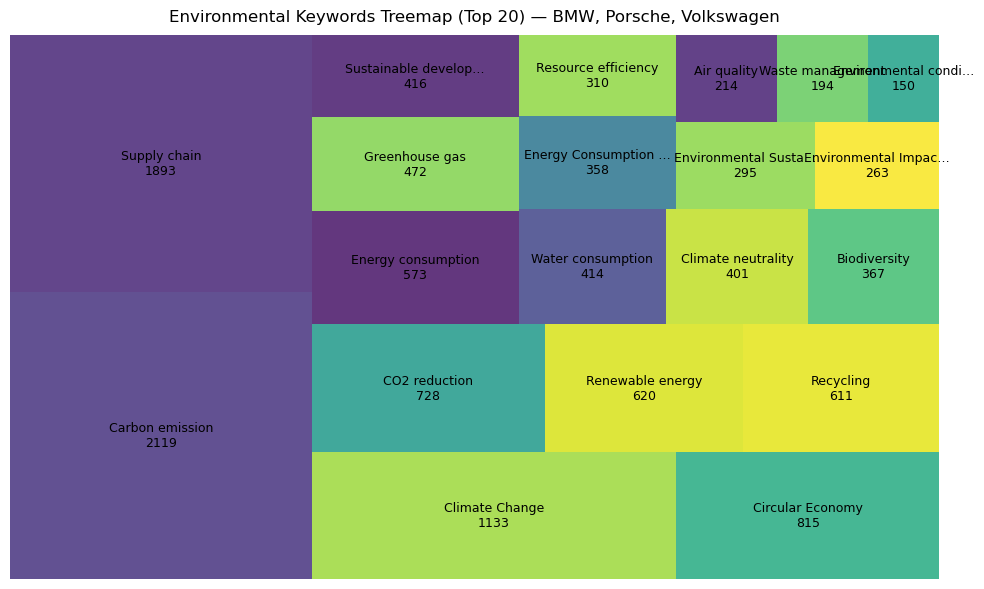

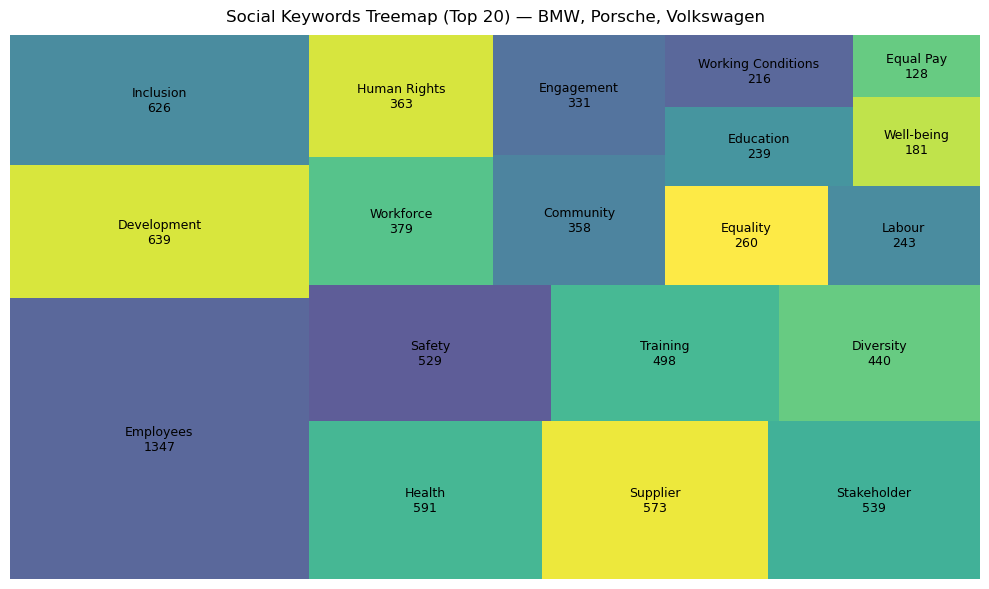

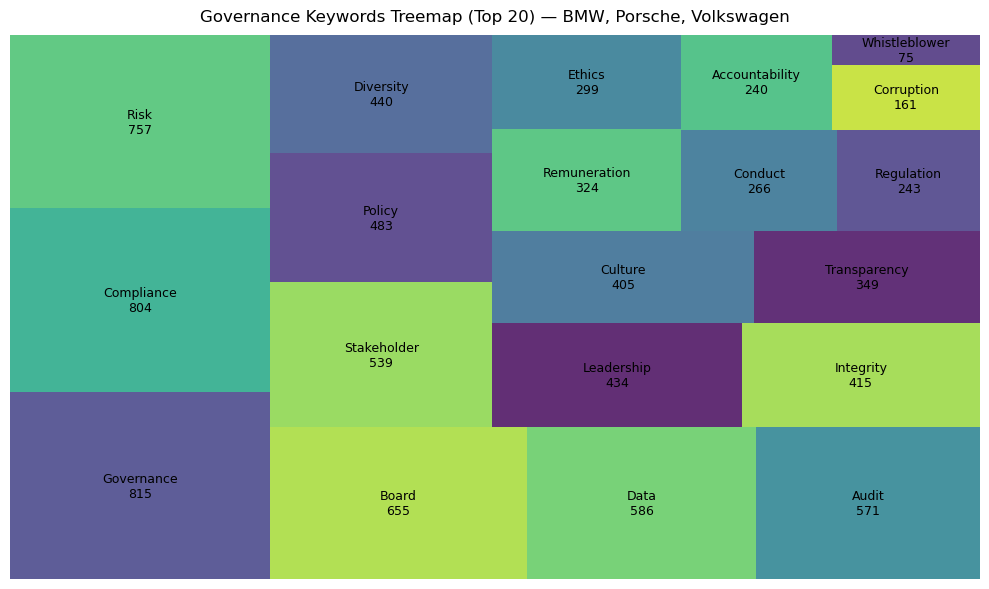

In [20]:
## VISUALISATION FUNCTIONS 

# Treemap (Tree Diagram) for ESG Keyword Frequencies

import squarify
import matplotlib.pyplot as plt
import pandas as pd

def plot_treemap(df, pillar_name, top_n=30, save_path=None):
    """
    Create a treemap (tree diagram) showing relative frequency of top-N keywords.
    Assumes df has [keyword_col, frequency_col] as its first two columns.
    """
    keyword_col = df.columns[0]
    freq_col = df.columns[1]

    # Clean and aggregate
    tidy = (df[[keyword_col, freq_col]].copy())
    tidy[keyword_col] = tidy[keyword_col].astype(str).str.strip()
    tidy[freq_col] = pd.to_numeric(tidy[freq_col], errors="coerce").fillna(0).astype(int)
    tidy = (tidy.groupby(keyword_col, as_index=False)[freq_col]
                 .sum()
                 .sort_values(freq_col, ascending=False)
                 .head(top_n))

    # Labels: show keyword and value (trim very long labels)
    def trim(s, maxlen=20):
        return s if len(s) <= maxlen else (s[:maxlen-1] + "…")
    labels = [f"{trim(k)}\n{v}" for k, v in zip(tidy[keyword_col], tidy[freq_col])]
    sizes = tidy[freq_col].values

    # Plot
    plt.figure(figsize=(10, 6))
    squarify.plot(
        sizes=sizes,
        label=labels,
        alpha=0.85,
        text_kwargs={"fontsize": 9, "wrap": True}
    )
    plt.axis("off")
    plt.title(f"{pillar_name} Keywords Treemap (Top {top_n}) — BMW, Porsche, Volkswagen", pad=10)
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, bbox_inches="tight", dpi=300)
    plt.show()

# ======== Environmental (Tree Diagram) ========
plot_treemap(Env_df, "Environmental", top_n=20, save_path=None) 

# ======== Social (Tree Diagram) ========
plot_treemap(Social_df, "Social", top_n=20, save_path=None)

# ======== Governance (Tree Diagram) ========
plot_treemap(Gov_df, "Governance", top_n=20, save_path=None)

In [21]:
# LOADING MAIN MODEL DATA (WEB-SCRAPED FEATURES + 3RD PARTY DATASET S&P BENCHMARK)

final = pd.read_csv(r"C:\Datasets for Business Analytics Project\FINAL_AUTOMOTIVE_DATASETS.csv")
sp = pd.read_csv(r"C:\Datasets for Business Analytics Project\S&P.csv")

final.columns = final.columns.str.strip()
sp.columns = sp.columns.str.strip()

final["Company"] = final["Company"].astype(str).str.strip().str.lower()
sp["Company"] = sp["Company"].astype(str).str.strip().str.lower()

if "S&P ESG Score" in sp.columns:
    sp = sp.rename(columns={"S&P ESG Score": "ESG_Score"})

sp["Company"] = sp["Company"].replace({
    "bmw": "bmw group",
    "porsche": "porsche ag",
    "volkswagen": "volkswagen group",
    "volkswagen ag": "volkswagen group"
})

df = final.merge(sp[["Company", "ESG_Score"]], on="Company", how="left")

target_companies = ["bmw group", "porsche ag", "volkswagen group"]
df = df[df["Company"].isin(target_companies)].copy()

print("✅ Companies in merged dataset:", df["Company"].unique())

df_clean = df.dropna(subset=["ESG_Score"]).copy()
print("Dataset shape after cleaning:", df_clean.shape)


# This block loads and harmonises the core analytical dataset by integrating web-scraped ESG disclosure features with externally benchmarked S&P ESG scores at the company level.
# Column names and firm identifiers are standardised to ensure accurate cross-dataset merging and to avoid entity-level mismatches that would bias model estimation.
# The dataset is explicitly filtered to the focal automotive firms (BMW Group, Porsche AG, Volkswagen Group) to maintain a consistent unit of analysis.
# Observations lacking benchmark ESG scores are removed to ensure that all remaining records are valid for supervised learning and model evaluation.
# This preprocessing step establishes a clean, aligned, and analytically reliable foundation for subsequent feature selection, modelling, and interpretation.


✅ Companies in merged dataset: ['bmw group' 'porsche ag' 'volkswagen group']
Dataset shape after cleaning: (24, 13)


In [22]:
# DEFINE FEATURES + TARGET

features = [
    "num_pages", "word_count",
    "env_per_1k", "social_per_1k", "gov_per_1k",
    "framework_per_1k", "assurance_per_1k",
    "transparency_per_1k", "risk_per_1k",
    "targets_by_2030_mentions"
]

X = df_clean[features].copy()
y = df_clean["ESG_Score"].copy()

# This block explicitly defines the model feature set capturing disclosure volume, ESG narrative intensity, transparency, assurance, risk acknowledgement, and forward-looking commitments, and separates these predictors from the S&P ESG score target for supervised learning.



Number of records per company:
Company
bmw group           8
porsche ag          8
volkswagen group    8


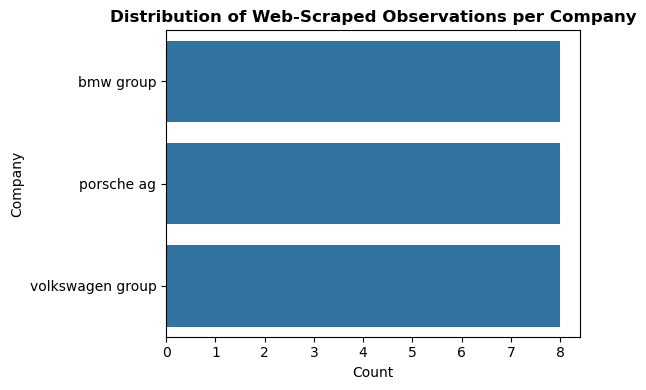


Summary statistics of key ESG and transparency indicators:
                     mean   std   min    max
env_per_1k           6.21  3.42  0.91  18.27
social_per_1k        4.73  1.96  1.25   9.48
gov_per_1k           9.00  7.39  0.00  32.93
transparency_per_1k  1.09  0.93  0.07   3.51
assurance_per_1k     1.82  1.35  0.00   4.22
risk_per_1k          3.34  2.01  0.15   9.70


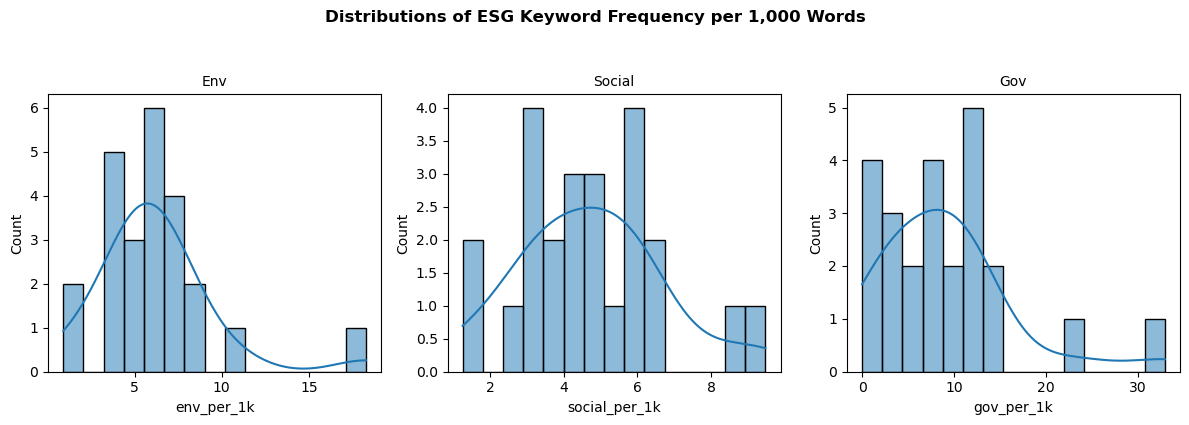

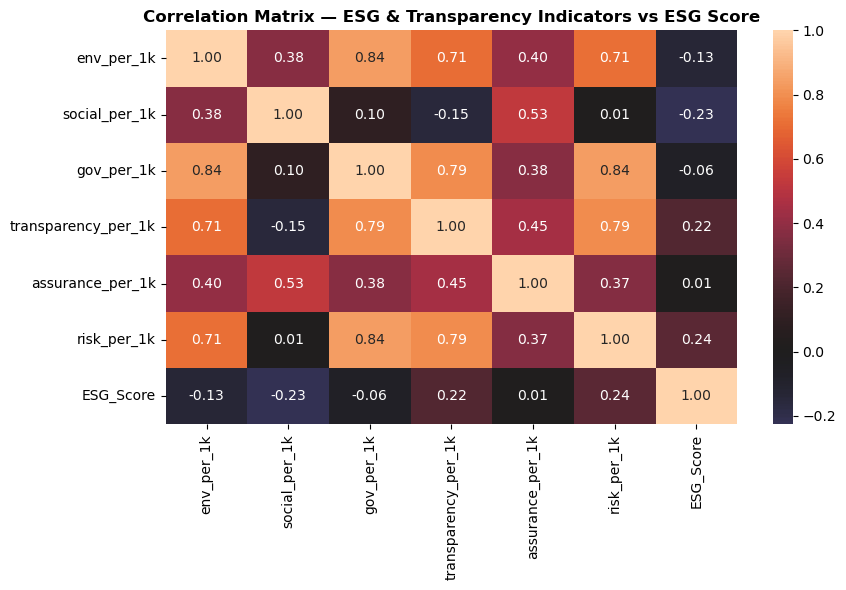


Top Correlated Features with ESG Score:
risk_per_1k            0.243
transparency_per_1k    0.222
assurance_per_1k       0.015
gov_per_1k            -0.061
env_per_1k            -0.132


In [23]:
# DESCRIPTIVE OVERVIEW (EDA)

print("\nNumber of records per company:")
print(df_clean["Company"].value_counts().to_string())

plt.figure(figsize=(6, 4))
sns.countplot(y="Company", data=df_clean, order=df_clean["Company"].value_counts().index)
plt.title("Distribution of Web-Scraped Observations per Company", weight="bold")
plt.xlabel("Count")
plt.ylabel("Company")
plt.tight_layout()
plt.show()

esg_vars = ["env_per_1k", "social_per_1k", "gov_per_1k", "transparency_per_1k", "assurance_per_1k", "risk_per_1k"]
summary_stats = df_clean[esg_vars].describe().T.round(2)
print("\nSummary statistics of key ESG and transparency indicators:")
print(summary_stats[["mean", "std", "min", "max"]])

plt.figure(figsize=(12, 4))
for i, col in enumerate(["env_per_1k", "social_per_1k", "gov_per_1k"], 1):
    plt.subplot(1, 3, i)
    sns.histplot(df_clean[col], kde=True, bins=15)
    plt.title(col.replace("_per_1k", "").capitalize(), fontsize=10)
plt.suptitle("Distributions of ESG Keyword Frequency per 1,000 Words", weight="bold", y=1.05)
plt.tight_layout()
plt.show()

corr_features = esg_vars + ["ESG_Score"]
corr_matrix = df_clean[corr_features].corr(numeric_only=True)

plt.figure(figsize=(9, 6))
sns.heatmap(corr_matrix, center=0, annot=True, fmt=".2f")
plt.title("Correlation Matrix — ESG & Transparency Indicators vs ESG Score", weight="bold")
plt.tight_layout()
plt.show()

cor_target = corr_matrix["ESG_Score"].drop("ESG_Score").sort_values(ascending=False)
print("\nTop Correlated Features with ESG Score:")
print(cor_target.head(5).round(3).to_string())



# This exploratory analysis examines the distribution, balance, and variability of ESG disclosure features across firms to identify potential data biases and structural differences prior to modelling.
# Summary statistics and distribution plots assess the scale, dispersion, and skewness of ESG keyword intensities, informing the suitability of features for regression-based learning.
# Correlation analysis provides an initial, non-causal assessment of linear associations between disclosure characteristics and external ESG scores, guiding subsequent model interpretation.
# Together, these diagnostics validate data quality, reveal dominant disclosure patterns, and support informed feature selection and model specification.


In [24]:
# PREPROCESSING (IMPUTE) + TRAIN/TEST SPLITS

imputer = SimpleImputer(strategy="mean")
X_imp = imputer.fit_transform(X)  # needed because models cannot accept NaN reliably

# ---- SVR needs scaling ----
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_imp)

X_train_svr, X_test_svr, y_train_svr, y_test_svr = train_test_split(
    X_scaled, y, test_size=0.30, random_state=42
)

# ---- Random Forest should be UN-SCALED (but imputed) ----
X_train_rf, X_test_rf, y_train_rf, y_test_rf = train_test_split(
    X_imp, y, test_size=0.30, random_state=42
)

# This block prepares the feature matrix by imputing missing values and applying scaling only where required, ensuring model compatibility without distorting tree-based learning.
# Separate train–test splits are created for SVR and Random Forest to reflect their different preprocessing assumptions and to enable fair, out-of-sample performance evaluation.


In [25]:
# BASE MODEL - SUPPORT VECTOR REGRESSION (SVR)
# ===============================================================
svr = SVR(kernel="rbf", C=100, epsilon=0.1, gamma="scale")
svr.fit(X_train_svr, y_train_svr)

y_pred_svr = svr.predict(X_test_svr)
r2_svr = r2_score(y_test_svr, y_pred_svr)
rmse_svr = np.sqrt(mean_squared_error(y_test_svr, y_pred_svr))

print(f"SVR (RBF) → R² = {r2_svr:.3f}, RMSE = {rmse_svr:.3f}")

# This block trains a non-linear SVR model on scaled ESG disclosure features and evaluates its out-of-sample predictive accuracy using R² and RMSE.


SVR (RBF) → R² = 0.171, RMSE = 11.194


In [26]:
# PRIMARY MODEL — RANDOM FOREST REGRESSION

rf = RandomForestRegressor(
    n_estimators=400,
    random_state=42,
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=1
)

rf.fit(X_train_rf, y_train_rf)

y_pred_rf = rf.predict(X_test_rf)
r2_rf = r2_score(y_test_rf, y_pred_rf)
rmse_rf = np.sqrt(mean_squared_error(y_test_rf, y_pred_rf))

print(f"Random Forest → R² = {r2_rf:.3f}, RMSE = {rmse_rf:.3f}")

# This block trains a Random Forest regression model on imputed ESG disclosure features and evaluates its out-of-sample performance, enabling robust, non-linear prediction and feature interpretability.


Random Forest → R² = 0.157, RMSE = 11.286


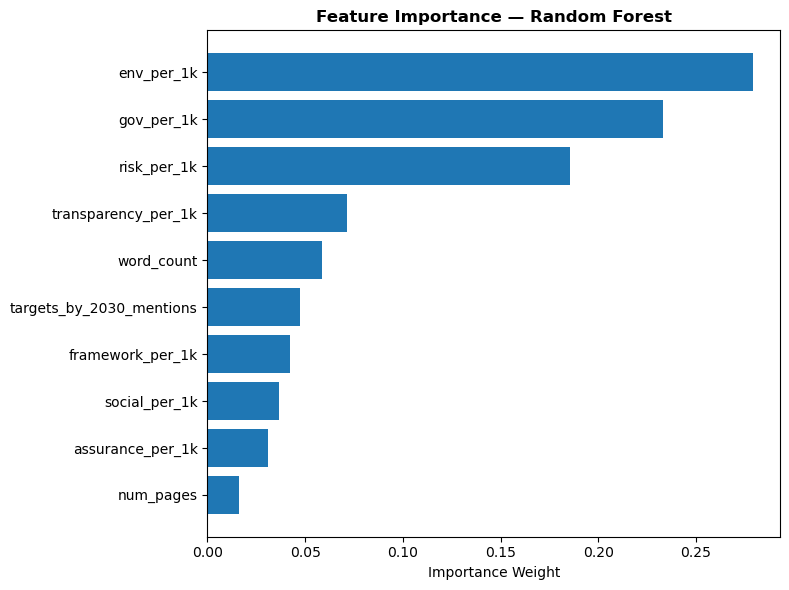

In [27]:
# FEATURE IMPORTANCE (RANDOM FOREST)

importances = rf.feature_importances_
order = np.argsort(importances)

plt.figure(figsize=(8, 6))
plt.barh(range(len(features)), importances[order])
plt.yticks(range(len(features)), np.array(features)[order])
plt.title("Feature Importance — Random Forest", weight="bold")
plt.xlabel("Importance Weight")
plt.tight_layout()
plt.show()

# This block visualises Random Forest feature importance scores to identify which ESG disclosure attributes contribute most to the model’s predictive performance.



--- Honesty Gap Results (Predicted – Actual ESG Score) ---
         Company   Year  ESG_Score  Predicted_ESG_RF  Honesty_Gap
       bmw group 2017.0       47.0           44.9250      -2.0750
       bmw group 2018.0       47.0           46.2525      -0.7475
       bmw group 2019.0       47.0           46.7550      -0.2450
       bmw group 2020.0       47.0           46.9550      -0.0450
       bmw group 2021.0       47.0           46.5725      -0.4275
       bmw group 2022.0       47.0           46.4725      -0.5275
       bmw group 2023.0       47.0           46.5375      -0.4625
       bmw group 2024.0       47.0           42.5150      -4.4850
      porsche ag 2017.0       21.0           31.9925      10.9925
      porsche ag 2018.0       21.0           32.6750      11.6750
      porsche ag 2019.0       21.0           27.5625       6.5625
      porsche ag 2020.0       21.0           31.1425      10.1425
      porsche ag 2021.0       21.0           28.4875       7.4875
      porsche ag

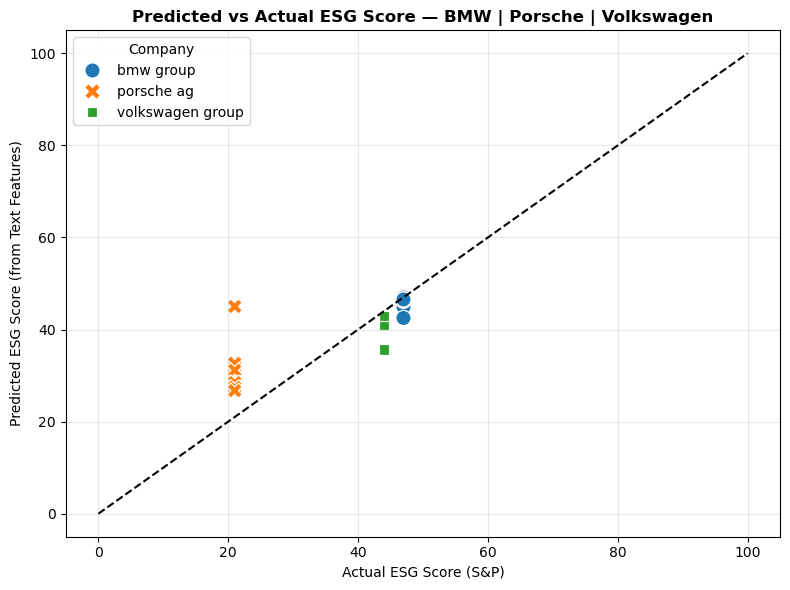

In [28]:
# HONESTY GAP (PREDICTED vs ACTUAL ESG SCORE) — USING Random Forest
df_clean = df_clean.copy()
df_clean["Predicted_ESG_RF"] = rf.predict(X_imp)  # same representation RF was trained on
df_compare = df_clean[["Company", "Year", "ESG_Score", "Predicted_ESG_RF"]].drop_duplicates().copy()
df_compare["Honesty_Gap"] = df_compare["Predicted_ESG_RF"] - df_compare["ESG_Score"]

print("\n--- Honesty Gap Results (Predicted – Actual ESG Score) ---")
print(df_compare.sort_values(["Company", "Year"]).to_string(index=False))

plt.figure(figsize=(8, 6))
sns.scatterplot(
    data=df_compare,
    x="ESG_Score",
    y="Predicted_ESG_RF",
    hue="Company",
    style="Company",
    s=120
)
plt.plot([0, 100], [0, 100], "--", color="black")
plt.title("Predicted vs Actual ESG Score — BMW | Porsche | Volkswagen", weight="bold")
plt.xlabel("Actual ESG Score (S&P)")
plt.ylabel("Predicted ESG Score (from Text Features)")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# This block computes the honesty gap by comparing Random Forest–predicted ESG scores with observed S&P ESG ratings at the company–year level.
# The resulting table and scatter plot enable diagnostic assessment of potential overstatement or understatement in sustainability disclosures relative to external benchmarks.


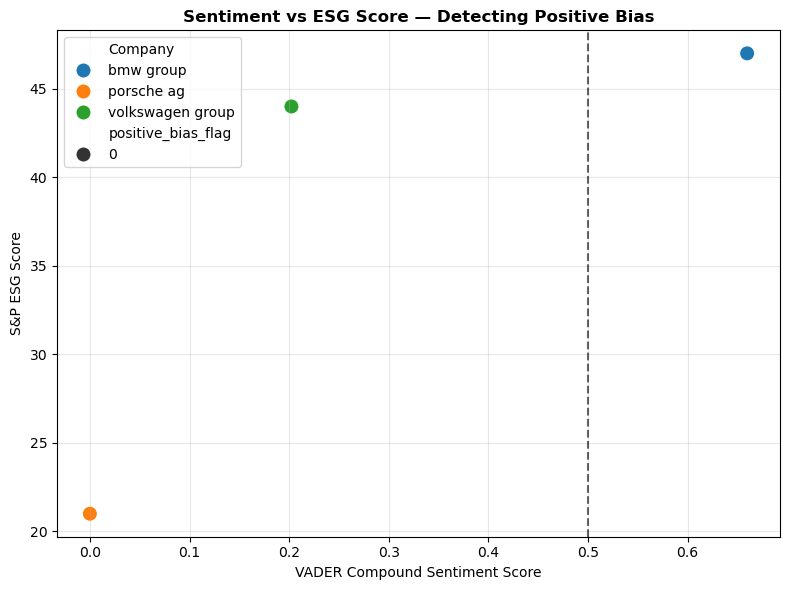

In [29]:
# SENTIMENT & POSITIVE BIAS FLAG (VADER) 

df_sent = df_clean.copy()

df_sent.loc[df_sent["Company"] == "bmw group", "sample_text"] = (
    "BMW Group reports balanced sustainability progress, focusing on innovation and emission reduction."
)
df_sent.loc[df_sent["Company"] == "porsche ag", "sample_text"] = (
    "Porsche AG emphasizes luxury performance while gradually integrating sustainable mobility concepts."
)
df_sent.loc[df_sent["Company"] == "volkswagen group", "sample_text"] = (
    "Volkswagen Group outlines bold sustainability targets but faces scrutiny regarding past environmental issues."
)

analyzer = SentimentIntensityAnalyzer()
df_sent["compound_score"] = df_sent["sample_text"].apply(
    lambda x: analyzer.polarity_scores(str(x))["compound"]
)

mean_esg = df_sent["ESG_Score"].mean()
df_sent["positive_bias_flag"] = (
    (df_sent["compound_score"] > 0.5) & (df_sent["ESG_Score"] < mean_esg)
).astype(int)

plt.figure(figsize=(8, 6))
sns.scatterplot(
    data=df_sent,
    x="compound_score",
    y="ESG_Score",
    hue="Company",
    style="positive_bias_flag",
    s=120
)
plt.axvline(0.5, linestyle="--", color="black", alpha=0.6)
plt.title("Sentiment vs ESG Score — Detecting Positive Bias", weight="bold")
plt.xlabel("VADER Compound Sentiment Score")
plt.ylabel("S&P ESG Score")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# This block applies VADER sentiment analysis to ESG-related narrative text and flags potential positive bias where optimistic tone coexists with below-average external ESG performance.


In [30]:
# MULTI-YEAR SENTIMENT SUMMARY (REQUIRES 'Year' COLUMN)

if "Year" not in df_sent.columns:
    raise KeyError("⚠️ 'Year' column missing. Ensure the dataset includes reporting years (e.g., 2017–2024).")

sent_year_summary = df_sent[["Company", "Year", "ESG_Score", "compound_score", "positive_bias_flag"]].copy()

sent_year_summary["Interpretation"] = np.select(
    [
        (sent_year_summary["positive_bias_flag"] == 1) & (sent_year_summary["compound_score"] > 0.5),
        (sent_year_summary["positive_bias_flag"] == 0) & (sent_year_summary["compound_score"] <= 0.5)
    ],
    [
        "Possible greenwashing (high tone, low ESG)",
        "Authentic or balanced reporting"
    ],
    default="Neutral alignment"
)

sent_year_summary = sent_year_summary.sort_values(["Company", "Year"])

print("\n--- Multi-Year Sentiment & Positive Bias Summary (2017–2024) ---")
print(sent_year_summary.to_string(index=False))

# This block constructs a longitudinal, company-year sentiment summary that interprets tone–performance alignment over time, supporting dynamic assessment of disclosure credibility and potential greenwashing patterns.



--- Multi-Year Sentiment & Positive Bias Summary (2017–2024) ---
         Company   Year  ESG_Score  compound_score  positive_bias_flag                  Interpretation
       bmw group 2017.0       47.0          0.6597                   0               Neutral alignment
       bmw group 2018.0       47.0          0.6597                   0               Neutral alignment
       bmw group 2019.0       47.0          0.6597                   0               Neutral alignment
       bmw group 2020.0       47.0          0.6597                   0               Neutral alignment
       bmw group 2021.0       47.0          0.6597                   0               Neutral alignment
       bmw group 2022.0       47.0          0.6597                   0               Neutral alignment
       bmw group 2023.0       47.0          0.6597                   0               Neutral alignment
       bmw group 2024.0       47.0          0.6597                   0               Neutral alignment
      p

In [31]:
# S&P vs SUSTAINALYTICS ESG COMPARISON (DATA-DRIVEN)


# Load Sustainalytics ESG Risk dataset
sustain_df = pd.read_csv(
    r"C:\Datasets for Business Analytics Project\Sustainalytics ESG Risk.csv"
)

# Standardise column names
sustain_df.columns = sustain_df.columns.str.strip()


# Identify Sustainalytics ESG risk score column
risk_col = [col for col in sustain_df.columns if "risk" in col.lower()]

if not risk_col:
    raise KeyError(
        "Required ESG risk score column is missing from the Sustainalytics dataset."
    )

sustain_df = sustain_df.rename(columns={
    risk_col[0]: "Sustainalytics_ESG_Risk"
})


# Standardise company names for merging
sustain_df["Company"] = (
    sustain_df["Company"]
    .astype(str)
    .str.strip()
    .str.lower()
)

sustain_df["Company"] = sustain_df["Company"].replace({
    "bmw": "bmw group",
    "bmw ag": "bmw group",
    "porsche": "porsche ag",
    "volkswagen": "volkswagen group",
    "volkswagen ag": "volkswagen group"
})

# Keep only target companies
sustain_df = sustain_df[sustain_df["Company"].isin(target_companies)].copy()


# Prepare S&P ESG scores from merged dataset

sp_df = (
    df_clean[["Company", "ESG_Score"]]
    .drop_duplicates()
    .copy()
)

# Merge S&P and Sustainalytics datasets

df_rating_compare = sp_df.merge(
    sustain_df[["Company", "Sustainalytics_ESG_Risk"]],
    on="Company",
    how="left"
)


# Ranking logic

# S&P: higher score indicates stronger ESG performance
# Sustainalytics: lower risk score indicates stronger ESG performance
df_rating_compare["S&P_Rank"] = df_rating_compare["ESG_Score"].rank(ascending=False)
df_rating_compare["Sustainalytics_Rank"] = df_rating_compare["Sustainalytics_ESG_Risk"].rank(ascending=True)

# Final output

print("\n=== S&P vs Sustainalytics ESG Comparison ===")
print(df_rating_compare.sort_values("Company").to_string(index=False))

df_rating_compare

# This block integrates Sustainalytics ESG risk ratings with S&P ESG scores to enable cross-rater comparison and assess consistency in external sustainability evaluations.
# By aligning firm identifiers and ranking performance under opposing scoring logics, it supports robustness checks and highlights potential ESG rating divergence.



=== S&P vs Sustainalytics ESG Comparison ===
         Company  ESG_Score  Sustainalytics_ESG_Risk  S&P_Rank  Sustainalytics_Rank
       bmw group       47.0                     23.1       1.0                  2.0
      porsche ag       21.0                     18.2       3.0                  1.0
volkswagen group       44.0                     28.9       2.0                  3.0


,Company,ESG_Score,Sustainalytics_ESG_Risk,S&P_Rank,Sustainalytics_Rank
0,bmw group,47.0,23.1,1.0,2.0
1,porsche ag,21.0,18.2,3.0,1.0
2,volkswagen group,44.0,28.9,2.0,3.0
